Explore SGD with the MNIST dataset
-----

![](http://myselph.de/mnistExamples.png)

[Based on this code](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py)

Check out this demo first: http://kurg.org/mnist/index.html?id=5

-----
Setup

In [1]:
reset -fs

In [2]:
import keras


Using TensorFlow backend.


----
Prepare data
----

In [63]:
from keras.datasets import mnist

In [64]:
# The data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [65]:
from matplotlib import pyplot
from scipy.misc import toimage

%matplotlib inline

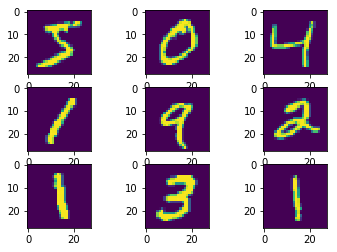

In [66]:
# Create a grid of 3x3 images
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(toimage(x_train[i]))
    
pyplot.show()

In [67]:
from keras import backend as K 

In [80]:
# Input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(input_shape)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
(28, 28, 1)


In [69]:
num_classes = 10

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

----
Define architecture
-----

In [70]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [83]:
# TODO: Add comment to each line of code decribing what it does
model = Sequential() # create the model

model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)) # add the first convolution layer, 32 denotes the number of filters
# kernel size, is the size of each filter, activation is the type of activation used
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

In [84]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total params: 1,199,882.0
Trainable params: 1,199,882.0
Non-trainable params: 0.0
____________________________________________________________

TODO: Write 1 or 2 sentences summarizing what this architecture is training to accomplish:

In [73]:
# This architecture is tryin to predict which class the model the data is 

----
SGD
----

In [74]:
from keras.optimizers import SGD

__TODO:__ Comment each line decribing what it does

Here is the SGD code: https://github.com/fchollet/keras/blob/master/keras/optimizers.py#L104

In [75]:
#```python
class SGD(Optimizer):
    """Stochastic gradient descent optimizer.
    Includes support for momentum,
    learning rate decay, and Nesterov momentum.
    # Arguments
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter updates momentum.
        decay: float >= 0. Learning rate decay over each update.
        nesterov: boolean. Whether to apply Nesterov momentum.
    """

    def __init__(self, lr=0.01, momentum=0., decay=0.,
                 nesterov=False, **kwargs):
        super(SGD, self).__init__(**kwargs) # global variable
        self.iterations = K.variable(0., name='iterations') # number of iterations to do
        self.lr = K.variable(lr, name='lr') # learning rate
        self.momentum = K.variable(momentum, name='momentum') #starting momentum, will be updated
        self.decay = K.variable(decay, name='decay') # weight decay
        self.initial_decay = decay
        self.nesterov = nesterov # use nesterov or not

    def get_updates(self, params, constraints, loss):
        grads = self.get_gradients(loss, params)
        self.updates = []

        lr = self.lr
        if self.initial_decay > 0: # this means we have a decay
            lr *= (1. / (1. + self.decay * self.iterations)) # decay the learning rate every ieteration
            # this is a function of the initial decay value as well as the number of iterations
            self.updates .append(K.update_add(self.iterations, 1)) ## store this update

        # momentum
        shapes = [K.get_variable_shape(p) for p in params] # global variable that belong to optimizer for SGD
        # Params is the size of the weight matrices we have for every layer
        moments = [K.zeros(shape) for shape in shapes] # start with a matrix of zeros to cache the gradient over time
        
        self.weights = [self.iterations] + moments # we are adding the iterations scaler to each element in moments
        
        for p, g, m in zip(params, grads, moments): # for loop
            v = self.momentum * m - lr * g  # velocity
            
            self.updates.append(K.update(m, v)) ### store the new velocity

            if self.nesterov: # if we are using this update formula, calculate below
                # formula for nesterov
                new_p = p + self.momentum * v - lr * g #add the current vecloty to the list of velocities
                # and subtract the learning rate from the current gradient , g
                # can think of as a compromise 
                
            else:
                # otherwise we are doing normal momentum updates
                # take the paramaters and add the current momentum
                new_p = p + v
                # momentum based stochastic gradient descent

            # apply constraints
            # some constrains on our function
            if p in constraints:
                c = constraints[p]
                new_p = c(new_p)

            self.updates.append(K.update(p, new_p))
            # update Keras with the new parameters (weights)
            
        return self.updates

    def get_config(self):
        ## pulling out the best variables you just computed
        config = {'lr': float(K.get_value(self.lr)),
                  'momentum': float(K.get_value(self.momentum)),
                  'decay': float(K.get_value(self.decay)),
                  'nesterov': self.nesterov}
        base_config = super(SGD, self).get_config()
        ### get these configuration values from the super optimizer
        return dict(list(base_config.items()) + list(config.items()))
#```

NameError: name 'Optimizer' is not defined

----
Train model
-----

In [26]:
batch_size = 128
epochs = 1 # Leave very small (2-3) for the sake of training speed

model.compile(optimizer=SGD(), 
                  loss=keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])

model.fit(x_train, 
            y_train,
            batch_size=batch_size, 
            epochs=epochs,
            verbose=True, 
            validation_split=.1)

score = model.evaluate(x_test, 
                       y_test, 
                       verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 201s - loss: 0.7769 - acc: 0.7994 - val_loss: 0.2654 - val_acc: 0.9225

In [27]:
x_test.shape

(10000, 28, 28, 1)

In [28]:
y_test.shape

(10000, 10)

------

Why does this model fit the test data, aka generalize, better than the MLP model from earlier in the term?

<br>

<details><summary>
Click here for a hint…
</summary>
How does the architecture differ?
</details>

In [ ]:
# We are using a convolution layer for out model!

Tune SGD hyperparameters to improve model performance:

```
lr: float >= 0. Learning rate.
momentum: float >= 0. Parameter updates momentum.
decay: float >= 0. Learning rate decay over each update.
nesterov: boolean. Whether to apply Nesterov momentum.
```

In [76]:
batch_size = 128
epochs = 1 # Leave very small (2-3) for the sake of training speed

model.compile(optimizer=SGD(lr=.01,decay=1e-6, momentum=0.9, nesterov=True), 
                  loss=keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])

model.fit(x_train, 
            y_train,
            batch_size=batch_size, 
            epochs=epochs,
            verbose=True, 
            validation_split=.1)

score = model.evaluate(x_test, 
                       y_test, 
                       verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 197s - loss: 0.3466 - acc: 0.8981 - val_loss: 0.1218 - val_acc: 0.9653

Which hyperparameter is most important for an optimitizer?

In [ ]:
# learning rate

In [31]:
x_train.shape

(60000, 28, 28, 1)

In [32]:
y_train.shape

(60000, 10)

In [33]:
x_test.shape

(10000, 28, 28, 1)

-----
Challenge Activities
-----

Try grid search with [hyperas](https://github.com/maxpumperla/hyperas)

In [42]:
from hyperas.distributions import uniform
from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional


<br>
<br> 
<br>

----

In [77]:
def data():
    return x_train, y_train, x_test, y_test 
def model_(x_train, y_train, x_test, y_test):
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
    # TODO: Add comment to each line of code decribing what it does
    model = Sequential() # create the model

    model.add(Conv2D({{choice([5, 10])}}, 
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape)) # add the first convolution layer, 32 denotes the number of filters
    # kernel size, is the size of each filter, activation is the type of activation used
    model.add(Conv2D({{choice([15, 20,25])}}, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense({{choice([128,200,250])}}, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))

#     # If we choose 'four', add an additional fourth layer
#     if conditional({{choice(['three', 'four'])}}) == 'four':
#         model.add(Dense(100))

#         # We can also choose between complete sets of layers

#         model.add({{choice([Dropout(0.5), Activation('linear')])}})
#         model.add(Activation('relu'))

#     model.add(Dense(10))
#     model.add(Activation('softmax'))

    
    batch_size = 128
    epochs = 1 # Leave very small (2-3) for the sake of training speed

    model.compile(optimizer=SGD(lr={{choice([.001,.01,.1,.15])}},decay=1e-6, 
                                momentum={{choice([.4,.6,.9])}}, nesterov=True), 
                      loss=keras.losses.categorical_crossentropy,
                      metrics=['accuracy'])

    model.fit(x_train, 
                y_train,
                batch_size=batch_size, 
                epochs=epochs,
                verbose=True, 
                validation_split=.1)

    score, acc = model.evaluate(x_test, y_test, verbose=0)


    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [78]:
# x_train, y_train, x_test, y_test = data()
best_run, best_model = optim.minimize(model=model_,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=2,
                                          trials=Trials())

print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/hyperas/optim.py
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/hyperas/optim.py
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/hyperas/optim.py
<ipython-input-78-2f6288012471>
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/zmqshell.py
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/ipkernel.py
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/kernelbase.py
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/kernelbase.py
/Users/jonathanhilgart/anaconda/envs/dl/lib/py

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jonathanhilgart/DSCI6005-student/week_3_image_classification/3_1_pm_optimitization_I/<ipython-input-78-2f6288012471>'